

---



---


# **Semester Project**
Submitted By: Alina Nawaz

Registration : B22F0087AI091

---


---





## **Setting Up PySpark**

In [ ]:
# Install PySpark
!pip install pyspark


In [ ]:
# Import PySpark
from pyspark.sql import SparkSession

# Create a Spark session
spark = SparkSession.builder.appName("Colab PySpark Setup").getOrCreate()

# Print Spark version
print(f"Spark version: {spark.version}")


Spark version: 3.5.3


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.0-bin-hadoop3"




---


# **Importing Libraries**
---



In [ ]:
!pip install pyspark pandas matplotlib seaborn scikit-learn


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier, NaiveBayes
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc




---


# **Data Preparation**


---




In [ ]:
from google.colab import files
uploaded = files.upload()


Saving heart731.csv to heart731.csv


In [ ]:
!ls


heart731.csv  sample_data


In [ ]:
df = spark.read.csv("heart731.csv", header=True, inferSchema=True)


In [ ]:
df = spark.read.csv("/content/heart731.csv", header=True, inferSchema=True)


In [ ]:
df = spark.read.csv("heart731.csv", header=True, inferSchema=True)
df.show()


+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
| 52|  1|  0|     125| 212|  0|      1|    168|    0|    1.0|    2|  2|   3|     0|
| 53|  1|  0|     140| 203|  1|      0|    155|    1|    3.1|    0|  0|   3|     0|
| 70|  1|  0|     145| 174|  0|      1|    125|    1|    2.6|    0|  0|   3|     0|
| 61|  1|  0|     148| 203|  0|      1|    161|    0|    0.0|    2|  1|   3|     0|
| 62|  0|  0|     138| 294|  1|      1|    106|    0|    1.9|    1|  3|   2|     0|
| 58|  0|  0|     100| 248|  0|      0|    122|    0|    1.0|    1|  0|   2|     1|
| 58|  1|  0|     114| 318|  0|      2|    140|    0|    4.4|    0|  3|   1|     0|
| 55|  1|  0|     160| 289|  0|      0|    145|    1|    0.8|    1|  1|   3|     0|
| 46|  1|  0|     120| 249|  0|      0|    144|    0|    0.8|    2|  0|   3|



---


# **Data Preprocessing**


---



In [ ]:
# Display schema of the DataFrame
df.printSchema()

# Check for null values in the dataset
from pyspark.sql.functions import col, isnan, when, count

df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Show some basic statistics
df.describe().show()


root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: integer (nullable = true)

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|  0|  0|  0|       0|   0|  0|      0|      0|    0|      0|    0|  0|   0|     0|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+

+-------+-----------------+------------------+

In [ ]:
# Replace null values with median or mean for numeric columns
from pyspark.sql.functions import mean

for column in df.columns:
    if column != 'target':
        mean_value = df.select(mean(col(column))).collect()[0][0]
        df = df.fillna({column: mean_value})


In [ ]:
from pyspark.ml.feature import StringIndexer

# Index 'sex' column
indexer = StringIndexer(inputCol="sex", outputCol="sex_index")
df = indexer.fit(df).transform(df)

# Drop the original 'sex' column if you don't need it
df = df.drop("sex")
df.show()


+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+---------+
|age| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|sex_index|
+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+---------+
| 52|  0|     125| 212|  0|      1|    168|    0|    1.0|    2|  2|   3|     0|      0.0|
| 53|  0|     140| 203|  1|      0|    155|    1|    3.1|    0|  0|   3|     0|      0.0|
| 70|  0|     145| 174|  0|      1|    125|    1|    2.6|    0|  0|   3|     0|      0.0|
| 61|  0|     148| 203|  0|      1|    161|    0|    0.0|    2|  1|   3|     0|      0.0|
| 62|  0|     138| 294|  1|      1|    106|    0|    1.9|    1|  3|   2|     0|      1.0|
| 58|  0|     100| 248|  0|      0|    122|    0|    1.0|    1|  0|   2|     1|      1.0|
| 58|  0|     114| 318|  0|      2|    140|    0|    4.4|    0|  3|   1|     0|      0.0|
| 55|  0|     160| 289|  0|      0|    145|    1|    0.8|    1|  1|   3|     0|      0.0|
| 46|  0| 

In [ ]:
# List of feature columns (excluding 'target')
feature_columns = ['age', 'sex_index', 'cp', 'trestbps', 'chol', 'fbs',
                   'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

# Combine features into a single vector using VectorAssembler
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df)
df.show()


+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+---------+--------------------+
|age| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|sex_index|            features|
+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+---------+--------------------+
| 52|  0|     125| 212|  0|      1|    168|    0|    1.0|    2|  2|   3|     0|      0.0|[52.0,0.0,0.0,125...|
| 53|  0|     140| 203|  1|      0|    155|    1|    3.1|    0|  0|   3|     0|      0.0|[53.0,0.0,0.0,140...|
| 70|  0|     145| 174|  0|      1|    125|    1|    2.6|    0|  0|   3|     0|      0.0|[70.0,0.0,0.0,145...|
| 61|  0|     148| 203|  0|      1|    161|    0|    0.0|    2|  1|   3|     0|      0.0|[61.0,0.0,0.0,148...|
| 62|  0|     138| 294|  1|      1|    106|    0|    1.9|    1|  3|   2|     0|      1.0|[62.0,1.0,0.0,138...|
| 58|  0|     100| 248|  0|      0|    122|    0|    1.0|    1|  0|   2|     1|      1.0|[58.0,1.0,0.0,100...|
|

In [ ]:
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
print(f"Training Data Count: {train_df.count()}, Testing Data Count: {test_df.count()}")


Training Data Count: 856, Testing Data Count: 169




---



---



---


# **Apply Machine Learning Algorithms**

---



---



---





---


# **Algorithm #1: Random Forest Classifier:**

---



# Train the Random Forest Classifier


In [ ]:
from pyspark.ml.classification import RandomForestClassifier

# Initialize Random Forest Classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="target", numTrees=200, maxDepth=10, seed=42)

# Train the model
rf_model = rf.fit(train_df)

# Make predictions on the test set
rf_predictions = rf_model.transform(test_df)


Random Forest Accuracy: 0.9822485207100592


# Evaluate the Random Forest Classifier

In [73]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluators for accuracy, precision, recall, F1-score
rf_evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction")

# Accuracy
rf_accuracy = rf_evaluator.setMetricName("accuracy").evaluate(rf_predictions)

# Precision
rf_precision = rf_evaluator.setMetricName("weightedPrecision").evaluate(rf_predictions)

# Recall
rf_recall = rf_evaluator.setMetricName("weightedRecall").evaluate(rf_predictions)

# F1 Score
rf_f1 = rf_evaluator.setMetricName("f1").evaluate(rf_predictions)

print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"Random Forest Precision: {rf_precision}")
print(f"Random Forest Recall: {rf_recall}")
print(f"Random Forest F1 Score: {rf_f1}")


Random Forest Accuracy: 0.9822485207100592
Random Forest Precision: 0.9828273732956007
Random Forest Recall: 0.9822485207100592
Random Forest F1 Score: 0.9822260322962773


# Visualize the Confusion Matrix

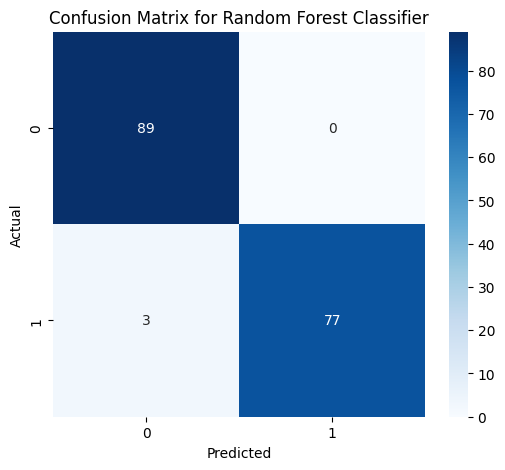

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Convert predictions to Pandas DataFrame for easier manipulation
rf_predictions_pd = rf_predictions.select("prediction", "target").toPandas()

# Calculate confusion matrix
conf_matrix = confusion_matrix(rf_predictions_pd['target'], rf_predictions_pd['prediction'])

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.title("Confusion Matrix for Random Forest Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Plot the ROC Curve

Applying Necessary modules for plotting ROC for random forest classifier

In [76]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
import matplotlib.pyplot as plt


Extracting the probability of the positive class (assuming class '1' is the positive class) and convert it to an RDD:

In [77]:
# Extract the probability of the positive class (class '1')
positive_class_probabilities = rf_predictions.select('probability').rdd.map(lambda row: row[0][1])


In [79]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt


In [80]:
# Get the model's summary
rf_summary = rf_model.summary


In [81]:
# Get ROC data
roc_data = rf_summary.roc.toPandas()


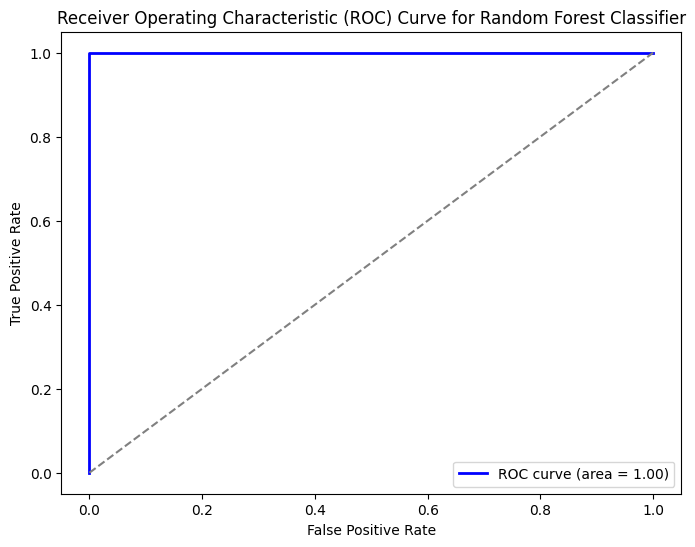

In [82]:
# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(roc_data['FPR'], roc_data['TPR'], color='blue', lw=2, label=f'ROC curve (area = {rf_summary.areaUnderROC:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest Classifier')
plt.legend(loc='lower right')
plt.show()


In [83]:
# Initialize evaluator
evaluator = BinaryClassificationEvaluator(labelCol='target', rawPredictionCol='rawPrediction')

# Compute AUC
auc_value = evaluator.evaluate(rf_predictions)
print(f"AUC: {auc_value}")


AUC: 1.0




---


# **Algorithm # 2: Logistic Regression**

---



In [67]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.mllib.evaluation import MulticlassMetrics

# Train Logistic Regression Model
lr = LogisticRegression(featuresCol="features", labelCol="target")
lr_model = lr.fit(train_df)
lr_predictions = lr_model.transform(test_df)


# Evaluate Logistic Regression Model

In [68]:
# Evaluators for accuracy, precision, recall, F1-score
lr_evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction")

# Accuracy
lr_accuracy = lr_evaluator.setMetricName("accuracy").evaluate(lr_predictions)

# Precision
lr_precision = lr_evaluator.setMetricName("weightedPrecision").evaluate(lr_predictions)

# Recall
lr_recall = lr_evaluator.setMetricName("weightedRecall").evaluate(lr_predictions)

# F1 Score
lr_f1 = lr_evaluator.setMetricName("f1").evaluate(lr_predictions)

print(f"Logistic Regression Accuracy: {lr_accuracy}")
print(f"Logistic Regression Precision: {lr_precision}")
print(f"Logistic Regression Recall: {lr_recall}")
print(f"Logistic Regression F1 Score: {lr_f1}")


Logistic Regression Accuracy: 0.8402366863905325
Logistic Regression Precision: 0.8560657665534748
Logistic Regression Recall: 0.8402366863905326
Logistic Regression F1 Score: 0.8394742268105455


# Visualize Confusion Matrix

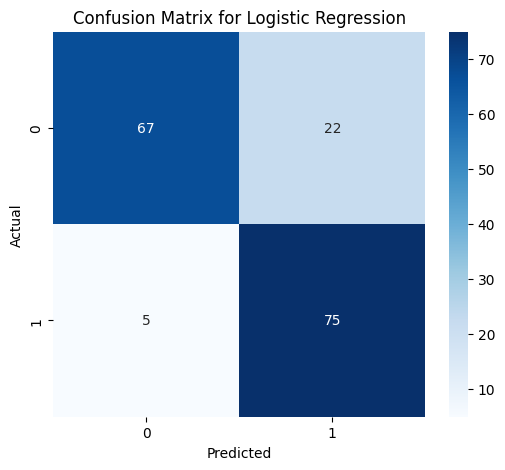

In [69]:
# Convert predictions to Pandas DataFrame for easier manipulation
lr_predictions_pd = lr_predictions.select("prediction", "target").toPandas()

# Calculate confusion matrix
conf_matrix = confusion_matrix(lr_predictions_pd['target'], lr_predictions_pd['prediction'])

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Visualize ROC Curve

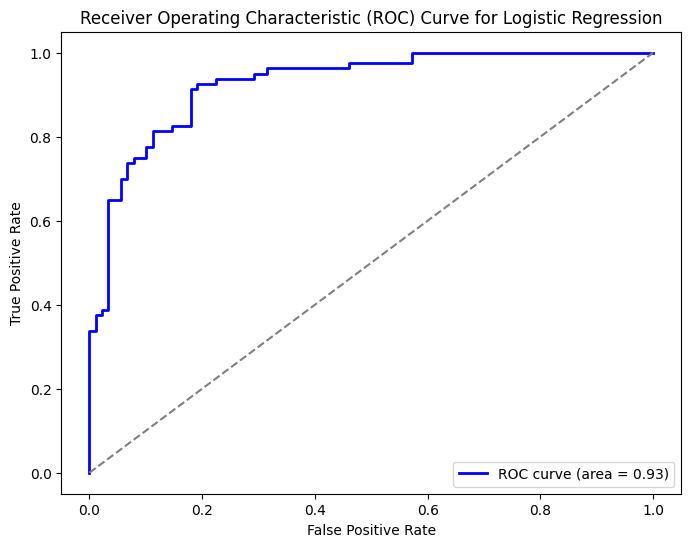

In [71]:
# Convert predictions to Pandas DataFrame
predictions_pd = lr_predictions.select("prediction", "target", "probability").toPandas()

# Get the probability of the positive class (index 1)
predictions_pd['positive_class_prob'] = predictions_pd['probability'].apply(lambda x: x[1])

# Compute ROC Curve using sklearn
from sklearn.metrics import roc_curve, auc

# Compute false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(predictions_pd['target'], predictions_pd['positive_class_prob'])

# Compute AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.show()


# Model Comparison Plot

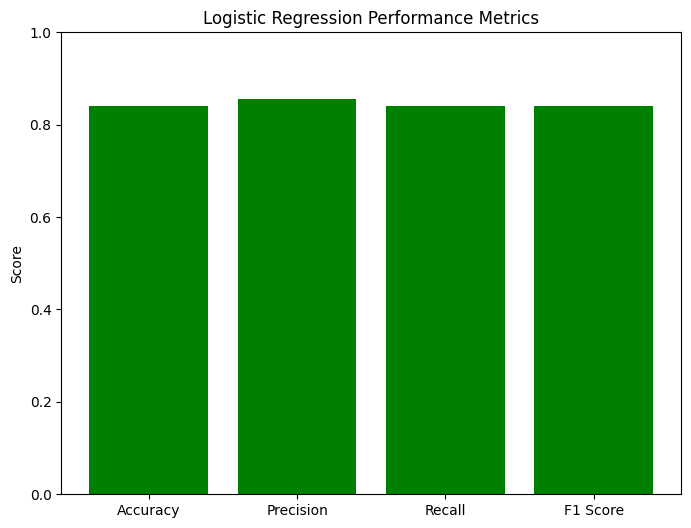

In [72]:
# Comparison of Metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [lr_accuracy, lr_precision, lr_recall, lr_f1]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color='green')
plt.title("Logistic Regression Performance Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()




---


# **Algorithm #3: K-Nearest Neighbors**


---



# **Through KMeans Clustering**

In [ ]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(featuresCol="features", k=2)  # Assuming binary classification
kmeans_model = kmeans.fit(train_df)
kmeans_predictions = kmeans_model.transform(test_df)

# Evaluate Clustering using Silhouette Score
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(featuresCol="features")
silhouette = evaluator.evaluate(kmeans_predictions)
print(f"Silhouette Score for KMeans: {silhouette}")


Silhouette Score for KMeans: 0.5984241870612792


# **Through Elbow Method**

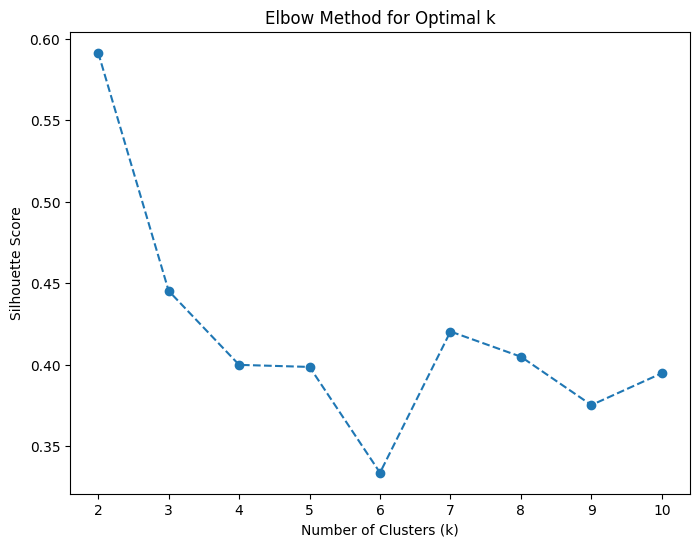

In [88]:
# Initialize evaluator
evaluator = ClusteringEvaluator()

# List to store WCSS values
wcss = []

# Range of k values to test
k_values = range(2, 11)

for k in k_values:
    # Initialize KMeans with k clusters
    kmeans = KMeans(k=k, featuresCol="features", predictionCol="prediction")

    # Fit the model
    model = kmeans.fit(df)

    # Make predictions
    predictions = model.transform(df)

    # Evaluate clustering by computing Silhouette score
    silhouette = evaluator.evaluate(predictions)

    # Append the Silhouette score to the list
    wcss.append(silhouette)

# Plotting the Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()


In [89]:
# Set the optimal number of clusters
optimal_k = 3  # Replace with the value identified from the Elbow Method

# Initialize KMeans with optimal k
kmeans = KMeans(k=optimal_k, featuresCol="features", predictionCol="prediction")

# Fit the model
kmeans_model = kmeans.fit(df)

# Make predictions
kmeans_predictions = kmeans_model.transform(df)


In [90]:
# Evaluate clustering by computing Silhouette score
silhouette = evaluator.evaluate(kmeans_predictions)
print(f"Silhouette Score for KMeans: {silhouette}")


Silhouette Score for KMeans: 0.44519511415413615


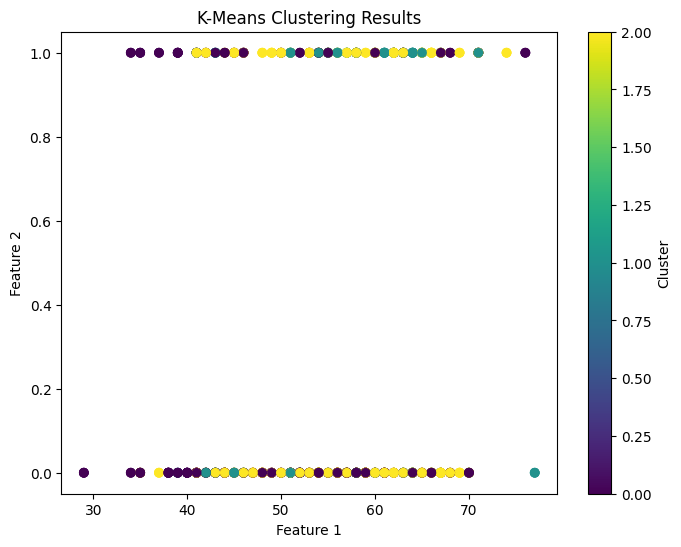

In [91]:
# Convert predictions to Pandas DataFrame
kmeans_predictions_pd = kmeans_predictions.select('prediction', 'features').toPandas()

# Extract features for plotting (assuming 2D features)
kmeans_predictions_pd['x'] = kmeans_predictions_pd['features'].apply(lambda x: x[0])
kmeans_predictions_pd['y'] = kmeans_predictions_pd['features'].apply(lambda x: x[1])

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(kmeans_predictions_pd['x'], kmeans_predictions_pd['y'], c=kmeans_predictions_pd['prediction'], cmap='viridis')
plt.title('K-Means Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster')
plt.show()




---



---



---



---

